In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
f(3.001)

20.014003000000002

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [6]:
plt.plot(xs, ys)


In [7]:
h = 0.001
x = 3

# Slope of the tangent line

(f(x + h) -f(x))/h

14.00300000000243

Let's look at derivative of a function with multiple inputs

In [8]:
# Inputs
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d_original = a * b + c      # 2*(-3) + 10
print(d_original)


4.0


In [9]:
# Bump 'a' by h

d_original = a * b + c     # 4.0

a += h
d_perturbed = a * b + c     # (2.001)*(-3) + 10 ≈ 3.997

slope = (d_perturbed - d_original) / h  # (3.997 - 4)/0.001 ≈ -3.0

print(slope)

-3.000000000010772


In [10]:
# Bump 'b' by h

d_original = a * b + c      # 4.0

b += h
d_perturbed = a * b + c     # 2*(-2.999) + 10 ≈ 4.002

slope = (d_perturbed - d_original) / h  # (4.002 - 4)/0.001 = 2.0

print(slope)

2.0001000000124947


*re-run the "d_original" and then direcly run "c"*

In [11]:
# Bump 'c' by h [restart]

c += h
d_perturbed = a * b + c     # 2*(-3) + 10.001 = 4.001

slope = (d_perturbed - d_original) / h  # (4.001 - 4)/0.001 = 1.0

print(slope)

3.000100000010164


Value object of micrograd

In [12]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self): # This is the representation of the object i.e. providing a nicer way of printing the object
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out



In [13]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

In [14]:
# addition

a + b
a.__add__(b) #internally it will call this - basically this is how behind the scenes it works

Value(data = -1.0)

In [15]:
# multiplication

a * b
#a.__mul__(b)

Value(data = -6.0)

In [16]:
# For a * b + c
(a.__mul__(b)).__add__(c)

Value(data = 4.0)

Computational Graphs

In [17]:
import math

In [18]:
class Value:

    def __init__(self, data, _childern=(), _op= '', label = ''):
        self.data = data
        self.grad = 0.0 # no effect - assuming every value does not effect the ouput 
        self._prev = set(_childern)
        self._op = _op
        self.label = label 
        
    def __repr__(self): # This is the representation of the object i.e. providing a nicer way of printing the object
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2**x)-1)/(math.exp(2**x)+1)
        out = Value(t, (self,), 'tanh')
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label ='e'
d = e + c; d.label ='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data = -8.0)

In [19]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [20]:
d._op

'+'

Visualization

In [21]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os

# Add Graphviz to the PATH
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
# Verify if Graphviz is in the PATH
import subprocess
print(subprocess.run(["dot", "-V"], capture_output=True, text=True).stdout)

In [23]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
       
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid +n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

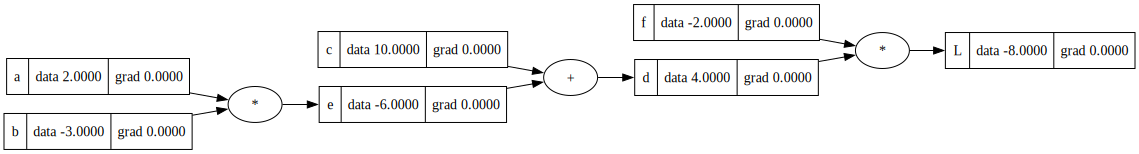

In [24]:
draw_dot(L)

Backpropogation

In [25]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [26]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


Gradient Check

In [27]:
def lol():
    
    h=0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label ='e'
    d = e + c; d.label ='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label ='e'
    d = e + c; d.label ='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

0.0


In [28]:
import matplotlib.pyplot as plt 
import numpy as np

Hyperbolic Tangent Activation Function

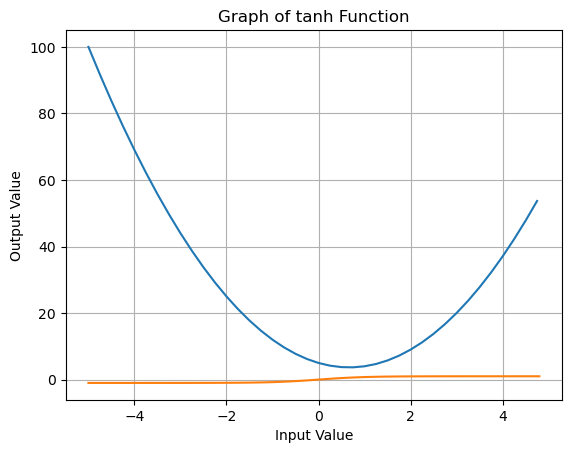

In [29]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.title("Graph of tanh Function")
plt.xlabel("Input Value")
plt.ylabel("Output Value")
plt.show()

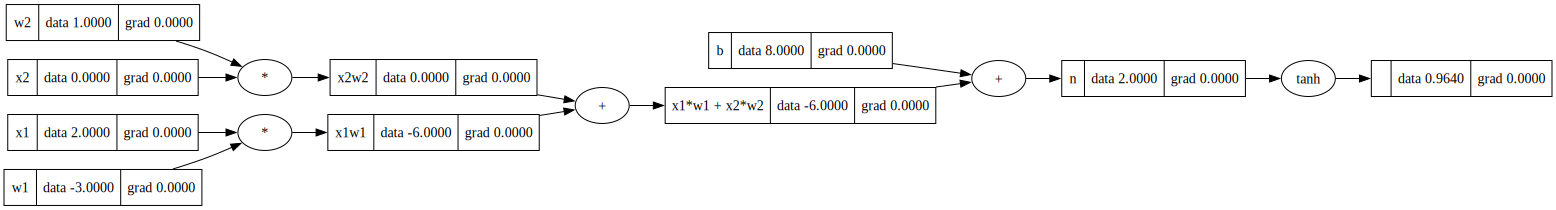

In [30]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(8.0, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
o = n.tanh()


#plot
draw_dot(o)

Backpropogation in action with tanh Activation  function - manual

In [31]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
o = n.tanh(); o.label = 'o'

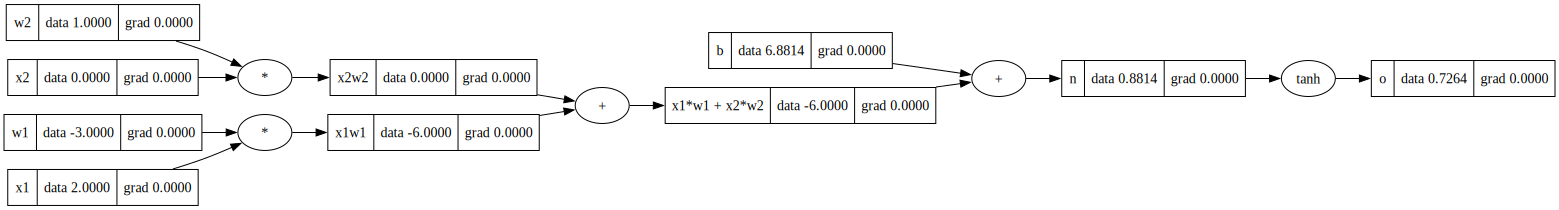

In [32]:
draw_dot(o)

In [33]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
a.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

In [34]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad 

In [35]:
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

In [36]:
# o = tanh(n)
# d0/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2 (since 1 - o.data**2 = 0.4723423728268237)
# do/dn = 0.5

In [37]:
class Value:

    def __init__(self, data, _childern=(), _op= '', label = ''):
        self.data = data
        self.grad = 0.0 # no effect - assuming every value does not effect the ouput
        self._backward = lambda : None 
        self._prev = set(_childern)
        self._op = _op
        self.label = label 
        
    def __repr__(self): # This is the representation of the object i.e. providing a nicer way of printing the object
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad  = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2**x)-1)/(math.exp(2**x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
            
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label ='e'
d = e + c; d.label ='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data = -8.0)

In [38]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
o = n.tanh(); o.label = 'o'

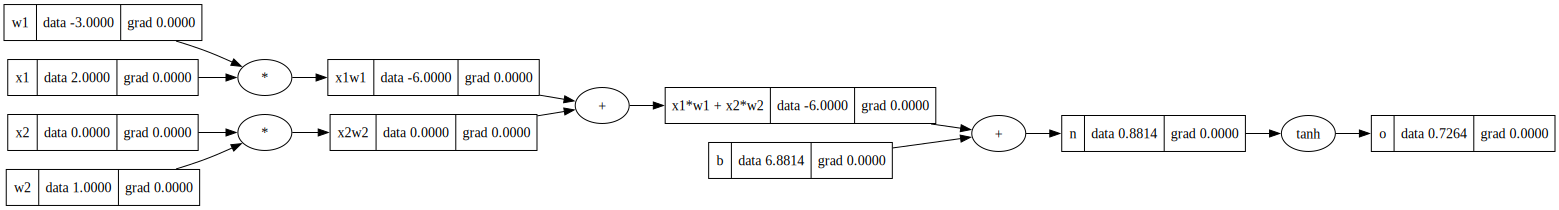

In [39]:
draw_dot(o)

In [40]:
o.grad = 1.0

In [41]:
o._backward()

In [42]:
n._backward()

In [43]:
b._backward()

In [44]:
x1w1x2w2._backward()

In [45]:
x1w1._backward()
x2w2._backward()

Topological Sort

In [46]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
o = n.tanh(); o.label = 'o'

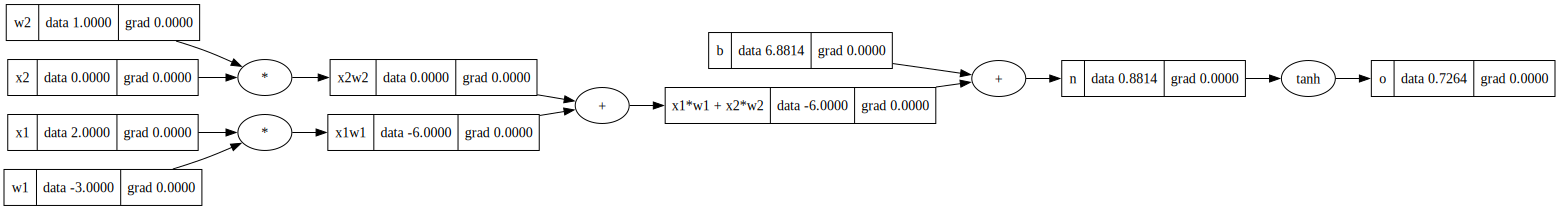

In [47]:
draw_dot(o)

In [48]:
o.grad = 1.0

topo = []
visited = set ()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

In [49]:
class Value:

    def __init__(self, data, _childern=(), _op= '', label = ''):
        self.data = data
        self.grad = 0.0 # no effect - assuming every value does not effect the ouput
        self._backward = lambda : None 
        self._prev = set(_childern)
        self._op = _op
        self.label = label 
        
    def __repr__(self): # This is the representation of the object i.e. providing a nicer way of printing the object
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad  += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2**x)-1)/(math.exp(2**x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out

    def backward(self):        

        topo = []
        visited = set ()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label ='e'
d = e + c; d.label ='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data = -8.0)

In [50]:
o.backward()

AttributeError: 'Value' object has no attribute 'backward'

Problem

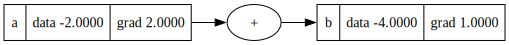

In [52]:
a = Value(-2.0, label='a')
b = a + a; b.label ='b'
b.backward()
draw_dot(b)


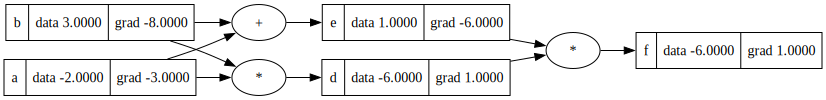

In [53]:
a = Value(-2.0, label='a')
b = Value(3.0, label ='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)


Solution

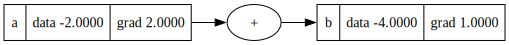

In [54]:
a = Value(-2.0, label='a')
b = a + a; b.label ='b'
b.backward()
draw_dot(b)

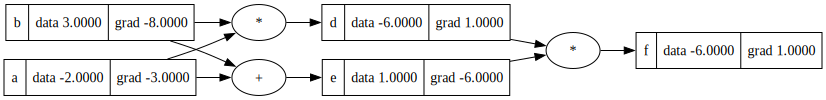

In [55]:
a = Value(-2.0, label='a')
b = Value(3.0, label ='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

break-up tanh

In [56]:
class Value:

    def __init__(self, data, _childern=(), _op= '', label = ''):
        self.data = data
        self.grad = 0.0 # no effect - assuming every value does not effect the ouput
        self._backward = lambda : None 
        self._prev = set(_childern)
        self._op = _op
        self.label = label 
        
    def __repr__(self): # This is the representation of the object i.e. providing a nicer way of printing the object
        return f"Value(data = {self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only supporting int/float for now
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out 
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # self - other
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2**x)-1)/(math.exp(2**x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):        

        topo = []
        visited = set ()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [57]:
# Subtraction

a = Value(2.0)
b = Value(4.0)
a - b

Value(data = -2.0)

In [58]:
# division in tanh function

a = Value(2.0)
b = Value(4.0)
#a / b

# divsion can also be reshuffled, which means we can say -
# a / b
# a * 1 / b
# a * (b**-1)

# _pow_ fuction will be called when we are trying to raise a value to some power, and 'other' will be that power.

# now redefing 
# forwardpass
#a / b   #Out: Value(data = 0.5)

#backwardpss
#b / a    #Out: Value(data = 2.0)


In [59]:
# exponential in tanh function

a = Value(2.0)
a.exp()

Value(data = 7.38905609893065)

In [60]:
# a = Value(2.0)
# 2 * a


# Basically this is not possible because Python calculates a * 2 as a.__mul__(2) and here 2 is not a Value object
# 2.__mul__(a) # this is not possible 

# that's why in Python there is a concept called __rmul__ which is called when the left operand does not support the operation. 
# rmul stands for reverse multiplication

#re-defing with rmul
a = Value(2.0)
2 * a

# and if python can't do 2 * a then __rmul__ will check if a knows how to multiply 2 (is there __rmul__ in Value). 
# Since there is, it will call __rmul__ and swap the order of operands.

Value(data = 4.0)

...

In [61]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
       
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid +n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [62]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
o = n.tanh(); o.label = 'o'
o.backward()

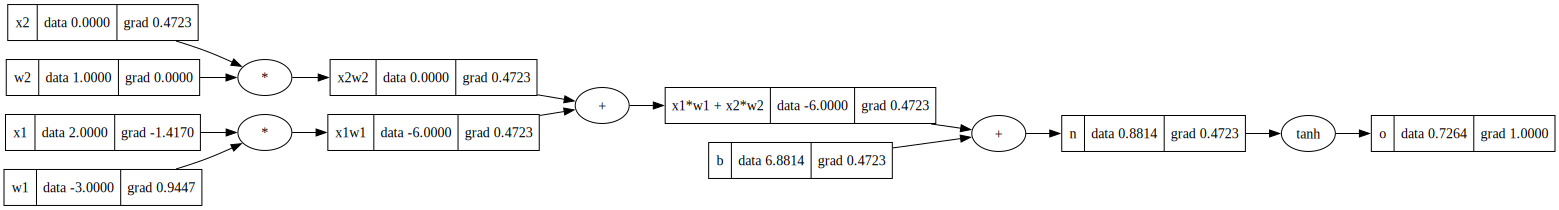

In [63]:
draw_dot(o)

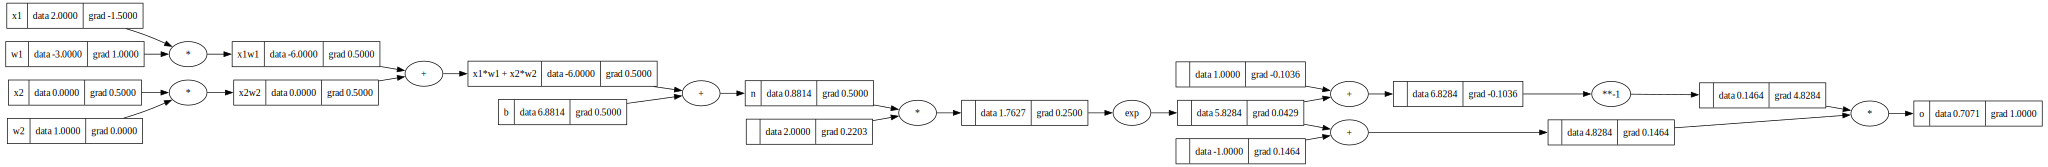

In [64]:
# Inputs x1, x2 (2 dimensionnal input)
x1  = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (synaptic strings for each inputs)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biad of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 +x2*w2 + b (neuron without activation function)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

#output of the neuron
e =  (2*n).exp()
o = (e - 1) / (e + 1)
# -------
o.label = 'o'
o.backward()
draw_dot(o) 

Working with tensor - PyTorch

In [65]:
!pip install torch

In [66]:
import torch

In [67]:

x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()       ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--------------')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
--------------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


Multilayer Perceptron (MLP)

In [76]:
import random

In [ ]:
class Neuron:
    def __init__(self, nin): #nin-> number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.w]
    
# Layer of Neuron
class Layer:
    def __init__(self, nin, nout): # nout = neuron output
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs [0] if len(outs)==1 else outs
    
    def parameters(self):
        params =[]
        for neuron in self.neurons:
            pa = neuron

# 3 input, 2 layers of 4 neurons each
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]  + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data = 0.8574106277654787)

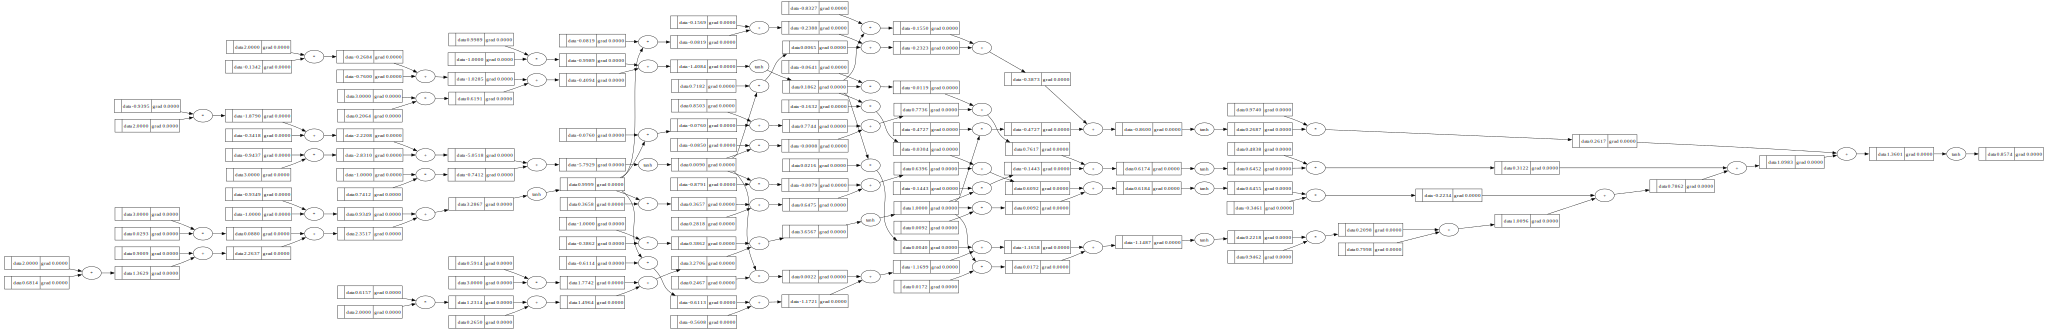

In [95]:
draw_dot(n(x))

In [122]:
# Binary classifier neural network

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired tagets

ypred = [n(x) for x in xs]
ypred

[Value(data = 0.8574106277654787),
 Value(data = 0.8660791906292225),
 Value(data = 0.881363617547695),
 Value(data = 0.8630134375942987)]

In [125]:
import math

In [133]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))
loss


Value(data = 7.060877654485529)

In [136]:
loss.backward()

In [137]:
n.layers[0].neurons[0].w[0].grad

-0.24217254530942817

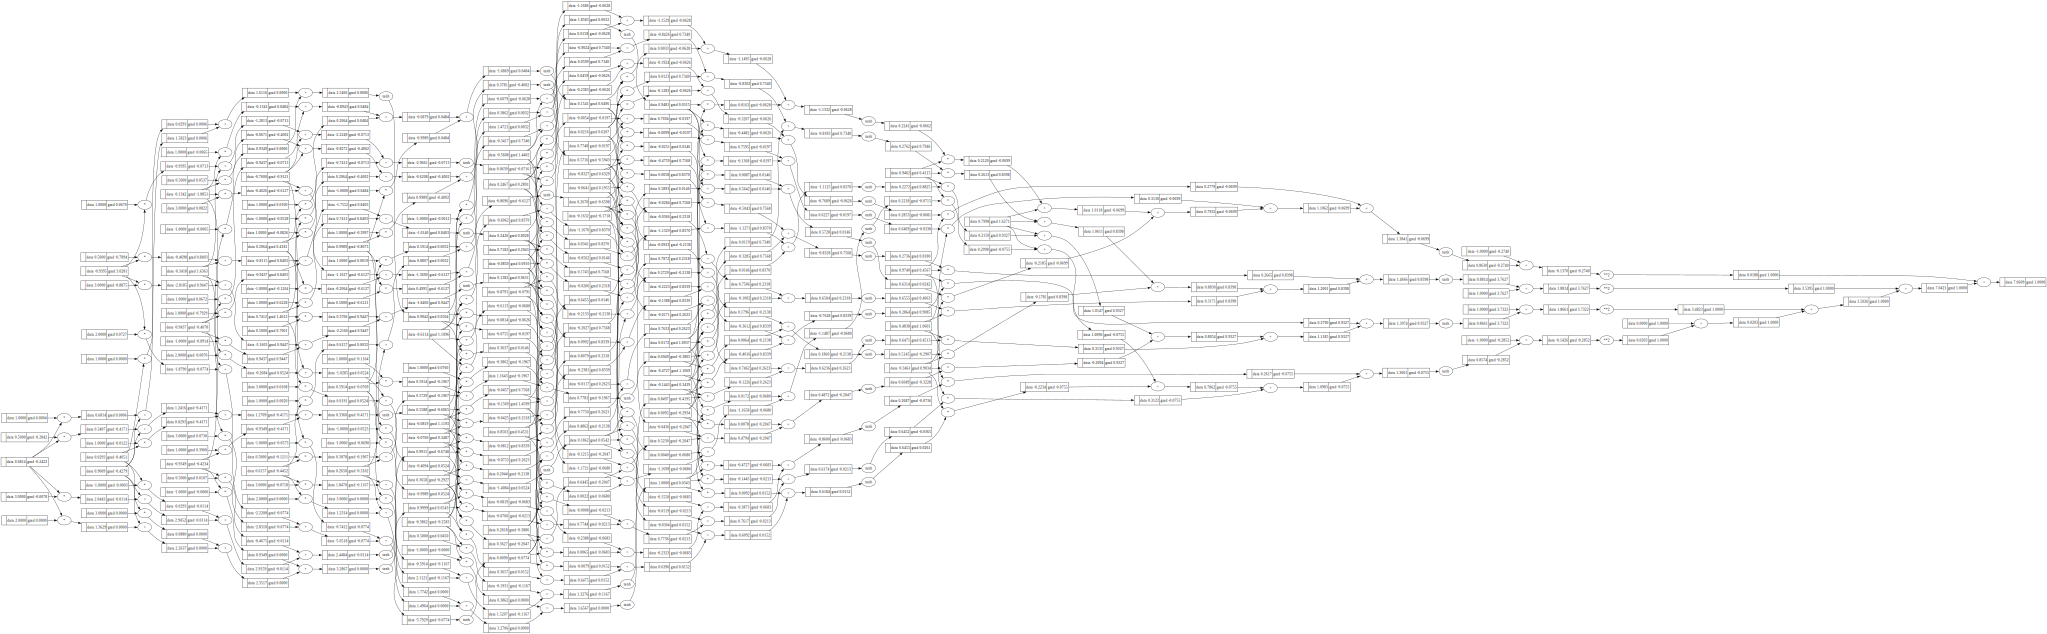

In [138]:
draw_dot(loss)